# Importing important libraries

In [ ]:
import pandas as pd
import numpy as np
import nltk
import json

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Transformers installation
! pip install transformers
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [ ]:
iphone_tweets = pd.read_csv("iphone_13_pre_release.csv")
print("Dataframe shape:", iphone_tweets.shape)
iphone_tweets.head()

Dataframe shape: (5000, 29)


,Unnamed: 0,_type,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,...,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card
0,0,snscrape.modules.twitter.Tweet,https://twitter.com/310log/status/144046576094...,2021-09-21 23:59:34+00:00,師匠当然買ってた iPad mini 6は、iPhone 13より欲しい端末ッ!!! ていう...,師匠当然買ってた iPad mini 6は、iPhone 13より欲しい端末ッ!!! ていう...,1440465760942313479,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,snscrape.modules.twitter.Tweet,https://twitter.com/sraj49/status/144046559468...,2021-09-21 23:58:54+00:00,"@lanawithanxiety With 5000 mah battery, best c...","@lanawithanxiety With 5000 mah battery, best c...",1440465594684379138,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,NaN,NaN,{'_type': 'snscrape.modules.twitter.Coordinate...,"{'_type': 'snscrape.modules.twitter.Place', 'f...",NaN,NaN,NaN
2,2,snscrape.modules.twitter.Tweet,https://twitter.com/musicalantlers/status/1440...,2021-09-21 23:58:28+00:00,@StevenRayMorris I currently have the Pro 12 M...,@StevenRayMorris I currently have the Pro 12 M...,1440465482025357320,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,1.440192e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,NaN
3,3,snscrape.modules.twitter.Tweet,https://twitter.com/itzjoshtho/status/14404654...,2021-09-21 23:58:25+00:00,"Fuming at how shite the IPhone 13 Pro Max is, ...","Fuming at how shite the IPhone 13 Pro Max is, ...",1440465469056565253,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,snscrape.modules.twitter.Tweet,https://twitter.com/eduardomesck/status/144046...,2021-09-21 23:58:08+00:00,"aí que ranço, as cases do iphone 12 não vão se...","aí que ranço, as cases do iphone 12 não vão se...",1440465399162630150,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,1,...,NaN,NaN,NaN,NaN,NaN,{'_type': 'snscrape.modules.twitter.Coordinate...,"{'_type': 'snscrape.modules.twitter.Place', 'f...",NaN,NaN,NaN


# Handling Missing Values

In [ ]:
iphone_tweets.isna().sum()

Unnamed: 0             0
_type                  0
url                    0
date                   0
rawContent             0
renderedContent        0
id                     0
user                   0
replyCount             0
retweetCount           0
likeCount              0
quoteCount             0
conversationId         0
lang                   0
source                 0
sourceUrl              0
sourceLabel            0
links               2855
media               4165
retweetedTweet      5000
quotedTweet         4868
inReplyToTweetId    4049
inReplyToUser       4049
mentionedUsers      3556
coordinates         4892
place               4892
hashtags            4405
cashtags            4982
card                4053
dtype: int64

In [ ]:
iphone_tweets.columns[iphone_tweets.isnull().any()]

Index(['links', 'media', 'retweetedTweet', 'quotedTweet', 'inReplyToTweetId',
       'inReplyToUser', 'mentionedUsers', 'coordinates', 'place', 'hashtags',
       'cashtags', 'card'],
      dtype='object')

Since, all of these columns are not that useful in our sentimental analysis or data exploration, we can safely ignore these null values, except the column place and coordinates, which we plan to explore after our sentimental analysis. Thus, to treat these two columns: 

In [ ]:
country_list = ['Not recorded']*len(iphone_tweets)

Initializing country names as not recorded, this way we can fetch the country name, and handle null values in that column

In [ ]:
for index in range(0, len(iphone_tweets)):
  country_data = iphone_tweets['place'][index]
  if(iphone_tweets['place'][index] is not np.nan):
    country_json_object = json.loads(iphone_tweets['place'][index].replace("'", '"'))
    country_list[index] = country_json_object['country']

In [ ]:
#json_object = json.loads(iphone_tweets['place'][1].replace("'", '"'))

In [ ]:
iphone_tweets['country'] = country_list

In [ ]:
iphone_tweets['country'].unique()

array(['Not recorded', 'Singapore', 'United States', 'Brazil',
       'Kingdom of Saudi Arabia', 'United Kingdom', 'Canada', 'Mexico',
       'Haiti', 'Argentina', 'Russia', 'Spain', 'Mali',
       'Republic of Serbia', 'Japan', 'Kenya', 'Nigeria', 'Liberia',
       'Germany', 'El Salvador', 'South Africa', 'India', 'Botswana',
       'Senegal', 'Ireland', 'France', 'The Netherlands',
       'Republic of the Philippines', 'Malaysia', 'Peru', 'Indonesia',
       'Latvia', 'Sri Lanka', 'Australia', 'Poland'], dtype=object)

In [ ]:
iphone_tweets.isnull().sum()

Unnamed: 0             0
_type                  0
url                    0
date                   0
rawContent             0
renderedContent        0
id                     0
user                   0
replyCount             0
retweetCount           0
likeCount              0
quoteCount             0
conversationId         0
lang                   0
source                 0
sourceUrl              0
sourceLabel            0
links               2855
media               4165
retweetedTweet      5000
quotedTweet         4868
inReplyToTweetId    4049
inReplyToUser       4049
mentionedUsers      3556
coordinates         4892
place               4892
hashtags            4405
cashtags            4982
card                4053
country                0
dtype: int64

# EDA

Let us explore importance of the tweets: </br>
To do so we're taking *likeCount* column, which signifies that more number of like on a tweet means more important the tweet is to us.

In [ ]:
import plotly.express as px

In [ ]:
iphone_tweets['likeCount']

0       0
1       0
2       0
3       0
4       2
       ..
4995    1
4996    0
4997    0
4998    3
4999    0
Name: likeCount, Length: 5000, dtype: int64

In [ ]:
max(iphone_tweets['likeCount'])

27206

In [ ]:
min(iphone_tweets['likeCount'])

0

Since, the max value in our tweet list count list is 27206 means that we might extract a few tweets that are relevant and will support our final aim of this project.

In [ ]:
iphone_tweets['likeCount'].mean()

17.1448

Although, we have higher importance since our mean of the like counts is less signifies that the count is skewed towards less number of likes. To show this we plot a histogram plot.

In [ ]:
df = px.data.tips()
fig = px.histogram(iphone_tweets, x='likeCount')
fig.show()

Looks like we have more number of 0 likes in the tweet which is reason of this skew. Let us try without the 0 values.

In [ ]:
iphone_tweets[iphone_tweets['likeCount']!=0]['likeCount']

4         2
5         2
6         3
7       185
8        40
       ... 
4987      1
4989      1
4993      6
4995      1
4998      3
Name: likeCount, Length: 1972, dtype: int64

In [ ]:
df = px.data.tips()
fig = px.histogram(iphone_tweets[iphone_tweets['likeCount']!=0], x='likeCount')
fig.show()

This helps us prove our hypothesis that the data is heavily skewed towards less value. That means the like count is not that valuable to explore. Most of the like counts lie in the range of 0-99.

In [ ]:
idx = np.where((iphone_tweets['likeCount']<99) & (iphone_tweets['likeCount']>0))
temp_df = iphone_tweets.loc[idx]

In [ ]:
df = px.data.tips()
fig = px.histogram(temp_df, x='likeCount')
fig.show()

In [ ]:
fig = px.scatter(temp_df, y='likeCount', size='likeCount', color="country",
                 hover_name="country", log_x=True, size_max=60)
fig.show()

Insights from this graph:


1.  Dominated country is in blue - United States - most tweets are from US.
2.  Most number of highest likes on tweet is from Brazil.
3.  Second domiated colour is pink(spain) and green(green).

How is this helpful?</br>
Since for now our data is limited, we cannot fully commit to the hypotheses. But if we in future get hold to a versatile and fully extended data with all the computation tweets that are needed we can easily tell if the tweets are going to help us or not. </br>
As, this data tells us that the most number of tweets are from US - which works in our favour as most number of crtiques, reviewers and smartphone pundits are from US. If we apply the same methodology on a fully extensible data we might receive more promising result.


In [ ]:
'''import plotly.express as px
df = px.data.tips()
fig = px.box(temp_df, y="likeCount", x="country")
fig.show()'''

'import plotly.express as px\ndf = px.data.tips()\nfig = px.box(temp_df, y="likeCount", x="country")\nfig.show()'

Like this feature analysis of likeCount we can estimate the same with others as well, given that we have a sophisticated and fully extensible data which covers the data for all the features pretty well. </br>
</br>
With these things in hand we can furthur extend and perform weighted sentimental analysis given importance to each review or tweet based on the relevance and importance that it deserves.</br>

# Sentimental Analysis of iphone 13 pre-release data

## Vader

In [ ]:
iphone_tweets.isna().sum()

Unnamed: 0             0
_type                  0
url                    0
date                   0
rawContent             0
renderedContent        0
id                     0
user                   0
replyCount             0
retweetCount           0
likeCount              0
quoteCount             0
conversationId         0
lang                   0
source                 0
sourceUrl              0
sourceLabel            0
links               2855
media               4165
retweetedTweet      5000
quotedTweet         4868
inReplyToTweetId    4049
inReplyToUser       4049
mentionedUsers      3556
coordinates         4892
place               4892
hashtags            4405
cashtags            4982
card                4053
country                0
dtype: int64

In [ ]:
iphone_tweets.dropna(subset=['rawContent'], inplace=True)

In [ ]:
iphone_tweets['rawContent'] = iphone_tweets['rawContent'].apply(lambda txt: txt.lower())

In [ ]:
stop_words=stopwords.words('english')
iphone_tweets['rawContent'] = iphone_tweets['rawContent'].apply(lambda txt: ' '.join([word for word in txt.split() if word not in stop_words]))

In [ ]:
iphone_tweets['rawContent'] = iphone_tweets['rawContent'].apply(lambda txt: sent_tokenize(txt))

In [ ]:
iphone_tweets['rawContent'] = iphone_tweets['rawContent'].apply(lambda txt: ' '.join(txt))

In [ ]:
sid1 = SentimentIntensityAnalyzer()

In [ ]:
iphone_tweets['score'] = iphone_tweets['rawContent'].apply(lambda txt: sid1.polarity_scores(txt))

In [ ]:
iphone_tweets['negative'] = iphone_tweets['score'].apply(lambda txt: txt['neg'])
iphone_tweets['neutral'] = iphone_tweets['score'].apply(lambda txt: txt['neu'])
iphone_tweets['positive'] = iphone_tweets['score'].apply(lambda txt: txt['pos'])
iphone_tweets['compound'] = iphone_tweets['score'].apply(lambda txt: txt['compound'])

In [ ]:
def polarity_score(compound):
    if compound > 0:
        return "positive"
    elif compound < 0:
        return "negative"
    elif compound == 0:
        return "neutral"

In [ ]:
iphone_tweets['sentiment'] = iphone_tweets['compound'].apply(lambda val: polarity_score(val))
iphone_tweets.head()

,Unnamed: 0,_type,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,...,hashtags,cashtags,card,country,score,negative,neutral,positive,compound,sentiment
0,0,snscrape.modules.twitter.Tweet,https://twitter.com/310log/status/144046576094...,2021-09-21 23:59:34+00:00,師匠当然買ってた ipad mini 6は、iphone 13より欲しい端末ッ!!! ていう...,師匠当然買ってた iPad mini 6は、iPhone 13より欲しい端末ッ!!! ていう...,1440465760942313479,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,Not recorded,"{'neg': 0.327, 'neu': 0.673, 'pos': 0.0, 'comp...",0.327,0.673,0.000,-0.6571,negative
1,1,snscrape.modules.twitter.Tweet,https://twitter.com/sraj49/status/144046559468...,2021-09-21 23:58:54+00:00,"@lanawithanxiety 5000 mah battery, best camera...","@lanawithanxiety With 5000 mah battery, best c...",1440465594684379138,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,Singapore,"{'neg': 0.0, 'neu': 0.662, 'pos': 0.338, 'comp...",0.000,0.662,0.338,0.8481,positive
2,2,snscrape.modules.twitter.Tweet,https://twitter.com/musicalantlers/status/1440...,2021-09-21 23:58:28+00:00,"@stevenraymorris currently pro 12 max, i’m “do...",@StevenRayMorris I currently have the Pro 12 M...,1440465482025357320,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,Not recorded,"{'neg': 0.046, 'neu': 0.686, 'pos': 0.268, 'co...",0.046,0.686,0.268,0.7783,positive
3,3,snscrape.modules.twitter.Tweet,https://twitter.com/itzjoshtho/status/14404654...,2021-09-21 23:58:25+00:00,"fuming shite iphone 13 pro max is, heart set b...","Fuming at how shite the IPhone 13 Pro Max is, ...",1440465469056565253,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,Not recorded,"{'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'comp...",0.333,0.667,0.000,-0.7579,negative
4,4,snscrape.modules.twitter.Tweet,https://twitter.com/eduardomesck/status/144046...,2021-09-21 23:58:08+00:00,"aí que ranço, cases iphone 12 não vão servir i...","aí que ranço, as cases do iphone 12 não vão se...",1440465399162630150,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,1,...,NaN,NaN,NaN,United States,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral


In [ ]:
iphone_tweets.loc[2]['rawContent']

'@stevenraymorris currently pro 12 max, i’m “downgrading” iphone 13 (the new camera enough uses pink 😍). like pro max agree hard hold/text using one hand.'

In [ ]:
iphone_tweets.loc[293]['rawContent']

"upgrade iphone 13 pro? here's reviews say (adwait patil - @digg) https://t.co/fk3lab3spw"

In [ ]:
iphone_tweets['sentiment']

0       negative
1       positive
2       positive
3       negative
4        neutral
          ...   
4995     neutral
4996    negative
4997    negative
4998    negative
4999     neutral
Name: sentiment, Length: 5000, dtype: object

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
color_code = {'negative': '#C41E3A', 'positive': '#0094DE', 'neutral':'#61727B'}

In [ ]:
fig = px.histogram(iphone_tweets, x='sentiment', color = 'sentiment', color_discrete_map = color_code)
fig.show()

In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [ ]:
tweets = " ".join(iphone_tweets['rawContent'])

word_cloud = WordCloud(stopwords = ENGLISH_STOP_WORDS,
                       width = 800, 
                       height = 400)

word_cloud.generate(tweets)

(-0.5, 799.5, 399.5, -0.5)

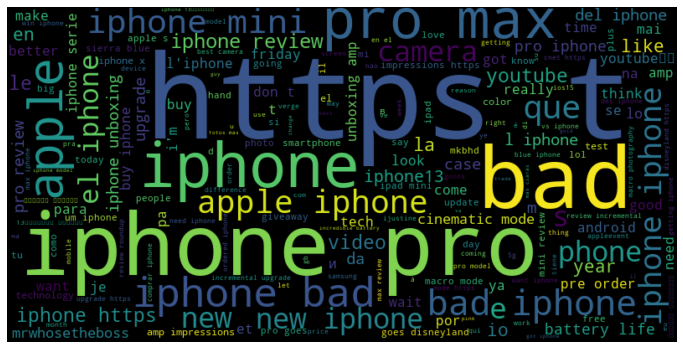

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')

## BERT

In [ ]:
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
classifier = pipeline('sentiment-analysis', model="nlptown/bert-base-multilingual-uncased-sentiment")

In [ ]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, from_pt=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
iphone_tweets['rawContent'][963]

'tim said iight get iphone 13 pro max https://t.co/ez4q0q5yvv'

In [ ]:
senti_score=[0]*len(iphone_tweets)
for ind in range(0, len(iphone_tweets)):
  senti_score[ind] = classifier(iphone_tweets['rawContent'][ind])[0]['score']

In [ ]:
senti_score

[0.4642724394798279,
 0.5497662425041199,
 0.4158676266670227,
 0.4691281020641327,
 0.6151019930839539,
 0.8201157450675964,
 0.37455087900161743,
 0.5400276184082031,
 0.28584736585617065,
 0.43940895795822144,
 0.6704105138778687,
 0.4007420241832733,
 0.40100547671318054,
 0.7153216004371643,
 0.3251173496246338,
 0.5347627401351929,
 0.44009432196617126,
 0.5891441702842712,
 0.40686628222465515,
 0.27453896403312683,
 0.3540796637535095,
 0.5329754948616028,
 0.3221833407878876,
 0.4635544419288635,
 0.5715993642807007,
 0.3221918046474457,
 0.3828694224357605,
 0.30770009756088257,
 0.3874564468860626,
 0.6797046661376953,
 0.23634368181228638,
 0.3760025203227997,
 0.26911962032318115,
 0.3767848312854767,
 0.25703006982803345,
 0.6897493600845337,
 0.6407431364059448,
 0.27956143021583557,
 0.5508185625076294,
 0.6857795715332031,
 0.24754147231578827,
 0.41541439294815063,
 0.3925062417984009,
 0.6281879544258118,
 0.3777484893798828,
 0.27507439255714417,
 0.6476434469223022

In [ ]:
iphone_tweets['BERT sentimental score'] = senti_score

In [ ]:
iphone_tweets.head()

,Unnamed: 0,_type,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,...,cashtags,card,country,score,negative,neutral,positive,compound,sentiment,BERT sentimental score
0,0,snscrape.modules.twitter.Tweet,https://twitter.com/310log/status/144046576094...,2021-09-21 23:59:34+00:00,師匠当然買ってた ipad mini 6は、iphone 13より欲しい端末ッ!!! ていう...,師匠当然買ってた iPad mini 6は、iPhone 13より欲しい端末ッ!!! ていう...,1440465760942313479,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,Not recorded,"{'neg': 0.327, 'neu': 0.673, 'pos': 0.0, 'comp...",0.327,0.673,0.000,-0.6571,negative,0.464272
1,1,snscrape.modules.twitter.Tweet,https://twitter.com/sraj49/status/144046559468...,2021-09-21 23:58:54+00:00,"@lanawithanxiety 5000 mah battery, best camera...","@lanawithanxiety With 5000 mah battery, best c...",1440465594684379138,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,Singapore,"{'neg': 0.0, 'neu': 0.662, 'pos': 0.338, 'comp...",0.000,0.662,0.338,0.8481,positive,0.549766
2,2,snscrape.modules.twitter.Tweet,https://twitter.com/musicalantlers/status/1440...,2021-09-21 23:58:28+00:00,"@stevenraymorris currently pro 12 max, i’m “do...",@StevenRayMorris I currently have the Pro 12 M...,1440465482025357320,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,Not recorded,"{'neg': 0.046, 'neu': 0.686, 'pos': 0.268, 'co...",0.046,0.686,0.268,0.7783,positive,0.415868
3,3,snscrape.modules.twitter.Tweet,https://twitter.com/itzjoshtho/status/14404654...,2021-09-21 23:58:25+00:00,"fuming shite iphone 13 pro max is, heart set b...","Fuming at how shite the IPhone 13 Pro Max is, ...",1440465469056565253,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,Not recorded,"{'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'comp...",0.333,0.667,0.000,-0.7579,negative,0.469128
4,4,snscrape.modules.twitter.Tweet,https://twitter.com/eduardomesck/status/144046...,2021-09-21 23:58:08+00:00,"aí que ranço, cases iphone 12 não vão servir i...","aí que ranço, as cases do iphone 12 não vão se...",1440465399162630150,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,1,...,NaN,NaN,United States,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral,0.615102


In [ ]:
def polarity_score_BERT(compound):
    if compound > 0.55:
        return "positive"
    elif compound < 0.45:
        return "negative"
    elif compound < 0.55 and compound > 0.45:
        return "neutral"

The bifurcation of score for BERT is a bit different, as it ranges from [0,1]. And since neutral range lie at a fine difference between negative and positive, which is 0.5, we need to set a different range for neutral which is [0.45, 0.55].

In [ ]:
iphone_tweets['BERT sentiment'] = iphone_tweets['BERT sentimental score'].apply(lambda val: polarity_score_BERT(val))

In [ ]:
fig = px.histogram(iphone_tweets, x='BERT sentiment', color = 'BERT sentiment', color_discrete_map = color_code)
fig.show()

# Sentimental Analysis for iphone 13 post-release data

## Vader

In [ ]:
iphone_tweets_post = pd.read_csv("iphone_13_post_release.csv")

In [ ]:
iphone_tweets_post.isna().sum()

Unnamed: 0             0
_type                  0
url                    0
date                   0
rawContent             0
renderedContent        0
id                     0
user                   0
replyCount             0
retweetCount           0
likeCount              0
quoteCount             0
conversationId         0
lang                   0
source                 0
sourceUrl              0
sourceLabel            0
links               3544
media               4208
retweetedTweet      5000
quotedTweet         4904
inReplyToTweetId    4026
inReplyToUser       4026
mentionedUsers      2257
coordinates         4907
place               4907
hashtags            2774
cashtags            4992
card                3983
dtype: int64

In [ ]:
iphone_tweets_post.dropna(subset=['rawContent'], inplace=True)

In [ ]:
iphone_tweets_post['rawContent'] = iphone_tweets_post['rawContent'].apply(lambda txt: txt.lower())

In [ ]:
stop_words=stopwords.words('english')
iphone_tweets_post['rawContent'] = iphone_tweets_post['rawContent'].apply(lambda txt: ' '.join([word for word in txt.split() if word not in stop_words]))

In [ ]:
iphone_tweets_post['rawContent'] = iphone_tweets_post['rawContent'].apply(lambda txt: sent_tokenize(txt))

In [ ]:
iphone_tweets_post['rawContent'] = iphone_tweets_post['rawContent'].apply(lambda txt: ' '.join(txt))

In [ ]:
sid1 = SentimentIntensityAnalyzer()

In [ ]:
iphone_tweets_post['score'] = iphone_tweets_post['rawContent'].apply(lambda txt: sid1.polarity_scores(txt))

In [ ]:
iphone_tweets_post['negative'] = iphone_tweets_post['score'].apply(lambda txt: txt['neg'])
iphone_tweets_post['neutral'] = iphone_tweets_post['score'].apply(lambda txt: txt['neu'])
iphone_tweets_post['positive'] = iphone_tweets_post['score'].apply(lambda txt: txt['pos'])
iphone_tweets_post['compound'] = iphone_tweets_post['score'].apply(lambda txt: txt['compound'])

In [ ]:
def polarity_score(compound):
    if compound > 0:
        return "positive"
    elif compound < 0:
        return "negative"
    elif compound == 0:
        return "neutral"

In [ ]:
iphone_tweets_post['sentiment'] = iphone_tweets_post['compound'].apply(lambda val: polarity_score(val))
iphone_tweets_post.head()

,Unnamed: 0,_type,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,...,place,hashtags,cashtags,card,score,negative,neutral,positive,compound,sentiment
0,0,snscrape.modules.twitter.Tweet,https://twitter.com/C18599370Chavez/status/157...,2022-09-21 23:59:56+00:00,iphone 14 vs iphone 13 - ¿cambia algo? https:/...,iPHONE 14 vs iPHONE 13 - ¿Cambia Algo? youtu.b...,1572737422684717058,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,{'_type': 'snscrape.modules.twitter.PlayerCard...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral
1,1,snscrape.modules.twitter.Tweet,https://twitter.com/niKz9GSF30KDCBa/status/157...,2022-09-21 23:59:22+00:00,apple iphone 13 (128gb) - ミッドナイトsimフリー 5g対応 am...,Apple iPhone 13 (128GB) - ミッドナイトSIMフリー 5G対応\nA...,1572737280397090816,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,{'_type': 'snscrape.modules.twitter.SummaryCar...,"{'neg': 0.0, 'neu': 0.841, 'pos': 0.159, 'comp...",0.000,0.841,0.159,0.1779,positive
2,2,snscrape.modules.twitter.Tweet,https://twitter.com/luvvzj/status/157273717906...,2022-09-21 23:58:58+00:00,iphone 13 camera yes! bad 💔,iphone 13 camera is so bad 💔,1572737179063054336,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,NaN,"{'neg': 0.399, 'neu': 0.316, 'pos': 0.284, 'co...",0.399,0.316,0.284,-0.2714,negative
3,3,snscrape.modules.twitter.Tweet,https://twitter.com/TheCopySloth/status/157273...,2022-09-21 23:58:26+00:00,@jenna_streety phones ‘spensive!! new iphone o...,@Jenna_Streety Phones are ‘spensive!! But now ...,1572737045402902529,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,...,NaN,NaN,NaN,NaN,"{'neg': 0.142, 'neu': 0.77, 'pos': 0.088, 'com...",0.142,0.770,0.088,0.1739,positive
4,4,snscrape.modules.twitter.Tweet,https://twitter.com/joabdeivyson/status/157273...,2022-09-21 23:57:54+00:00,meu cunhado comprou 166 cotas sorteio iphone 1...,Meu cunhado comprou 166 cotas no sorteio do iP...,1572736910254039040,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral


In [ ]:
iphone_tweets_post.loc[2]['rawContent']

'iphone 13 camera yes! bad 💔'

In [ ]:
iphone_tweets_post.loc[293]['rawContent']

'iphone 13 service acting real bad anyone else connection issues?'

In [ ]:
iphone_tweets_post['sentiment']

0        neutral
1       positive
2       negative
3       positive
4        neutral
          ...   
4995     neutral
4996    positive
4997    positive
4998     neutral
4999     neutral
Name: sentiment, Length: 5000, dtype: object

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
color_code = {'negative': '#C41E3A', 'positive': '#0094DE', 'neutral':'#61727B'}

In [ ]:
fig = px.histogram(iphone_tweets_post, x='sentiment', color = 'sentiment', color_discrete_map = color_code)
fig.show()

In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [ ]:
tweets = " ".join(iphone_tweets_post['rawContent'])

word_cloud = WordCloud(stopwords = ENGLISH_STOP_WORDS,
                       width = 800, 
                       height = 400)

word_cloud.generate(tweets)

(-0.5, 799.5, 399.5, -0.5)

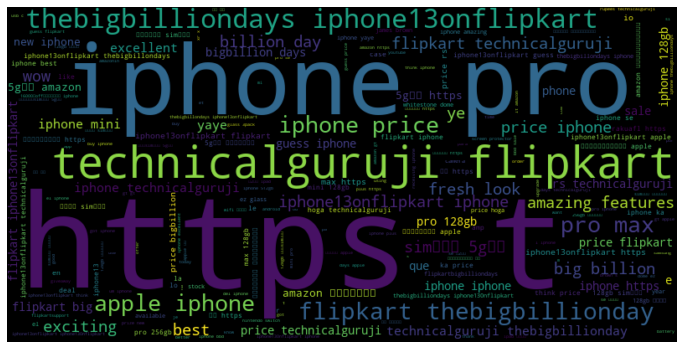

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')

## BERT

In [ ]:
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
classifier = pipeline('sentiment-analysis', model="nlptown/bert-base-multilingual-uncased-sentiment")

In [ ]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, from_pt=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
iphone_tweets_post['rawContent'][963]

'apple iphone fresh look 13 mini (128gb) https://t.co/gvnegodene 73,990 rs. 64,900 rs. [9,090 rs. off] #amazongreatindianfestivalsale'

In [ ]:
senti_score_post=[0]*len(iphone_tweets_post)
for ind in range(0, len(iphone_tweets_post)):
  senti_score_post[ind] = classifier(iphone_tweets_post['rawContent'][ind])[0]['score']

In [ ]:
senti_score_post

[0.2588058412075043,
 0.3113737106323242,
 0.6436103582382202,
 0.8898530006408691,
 0.3571403920650482,
 0.8183369040489197,
 0.6764004826545715,
 0.5158019661903381,
 0.43126145005226135,
 0.5972422957420349,
 0.8803989887237549,
 0.801010012626648,
 0.42169398069381714,
 0.532625675201416,
 0.477571040391922,
 0.8222318291664124,
 0.306930273771286,
 0.35216349363327026,
 0.5997455716133118,
 0.4096755087375641,
 0.27169525623321533,
 0.3061484396457672,
 0.47820526361465454,
 0.5358189344406128,
 0.46801701188087463,
 0.49316927790641785,
 0.5583497285842896,
 0.3260362148284912,
 0.42299309372901917,
 0.7565783858299255,
 0.398056298494339,
 0.35541874170303345,
 0.3297308087348938,
 0.26047301292419434,
 0.2642262578010559,
 0.4092676341533661,
 0.6613219976425171,
 0.2369839996099472,
 0.3715854287147522,
 0.6363552212715149,
 0.4448632299900055,
 0.5749080777168274,
 0.3484514057636261,
 0.5269419550895691,
 0.658100426197052,
 0.33152854442596436,
 0.3080654740333557,
 0.48452

In [ ]:
iphone_tweets_post['BERT sentimental score'] = senti_score_post

In [ ]:
iphone_tweets_post.head()

,Unnamed: 0,_type,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,...,hashtags,cashtags,card,score,negative,neutral,positive,compound,sentiment,BERT sentimental score
0,0,snscrape.modules.twitter.Tweet,https://twitter.com/C18599370Chavez/status/157...,2022-09-21 23:59:56+00:00,iphone 14 vs iphone 13 - ¿cambia algo? https:/...,iPHONE 14 vs iPHONE 13 - ¿Cambia Algo? youtu.b...,1572737422684717058,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,{'_type': 'snscrape.modules.twitter.PlayerCard...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral,0.258806
1,1,snscrape.modules.twitter.Tweet,https://twitter.com/niKz9GSF30KDCBa/status/157...,2022-09-21 23:59:22+00:00,apple iphone 13 (128gb) - ミッドナイトsimフリー 5g対応 am...,Apple iPhone 13 (128GB) - ミッドナイトSIMフリー 5G対応\nA...,1572737280397090816,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,{'_type': 'snscrape.modules.twitter.SummaryCar...,"{'neg': 0.0, 'neu': 0.841, 'pos': 0.159, 'comp...",0.000,0.841,0.159,0.1779,positive,0.311374
2,2,snscrape.modules.twitter.Tweet,https://twitter.com/luvvzj/status/157273717906...,2022-09-21 23:58:58+00:00,iphone 13 camera yes! bad 💔,iphone 13 camera is so bad 💔,1572737179063054336,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,"{'neg': 0.399, 'neu': 0.316, 'pos': 0.284, 'co...",0.399,0.316,0.284,-0.2714,negative,0.643610
3,3,snscrape.modules.twitter.Tweet,https://twitter.com/TheCopySloth/status/157273...,2022-09-21 23:58:26+00:00,@jenna_streety phones ‘spensive!! new iphone o...,@Jenna_Streety Phones are ‘spensive!! But now ...,1572737045402902529,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,...,NaN,NaN,NaN,"{'neg': 0.142, 'neu': 0.77, 'pos': 0.088, 'com...",0.142,0.770,0.088,0.1739,positive,0.889853
4,4,snscrape.modules.twitter.Tweet,https://twitter.com/joabdeivyson/status/157273...,2022-09-21 23:57:54+00:00,meu cunhado comprou 166 cotas sorteio iphone 1...,Meu cunhado comprou 166 cotas no sorteio do iP...,1572736910254039040,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,...,NaN,NaN,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral,0.357140


In [ ]:
def polarity_score_BERT(compound):
    if compound > 0.45:
        return "positive"
    elif compound < 0.4:
        return "negative"
    elif compound < 0.55 and compound > 0.4:
        return "neutral"

In [ ]:
iphone_tweets_post['BERT sentiment'] = iphone_tweets_post['BERT sentimental score'].apply(lambda val: polarity_score_BERT(val))

In [ ]:
fig = px.histogram(iphone_tweets_post, x='BERT sentiment', color = 'BERT sentiment', color_discrete_map = color_code)
fig.show()